# Ecuaciones de Onda

Vamos a construir una aplicación de Cactus *completa*. Es decir, vamos a dar datos iniciales determinados por parámetros y vamos a evolucionarlos con las ecuaciones de nuestra elección.

En este caso, vamos a trabajar con la ecuación de onda.

La evolución de de esta ecuación se da con el Método de Líneas (MoL). Este Thorn abstrae la integración en el tiempo de una manera muy sencilla.

In [1]:
%cd ~/CactusTutorial/CactusFW2/

/home/santiago/CactusTutorial/CactusFW2


Este thorn se llamará **WaveToy**. Le creamos sus directorios y los archivos de interfaz, parámetros y programación.

Como siempre, puedes empezar de cero borrando todo.

In [2]:
!rm -rf ~/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/

In [3]:
%mkdir -p arrangements/Utils/WaveToy/src/include arrangements/Utils/WaveToy/par arrangements/Utils/WaveToy/doc arrangements/Utils/WaveToy/test

* El archivo de `interface.ccl`
    
    No sólo estamos declarando las funciones $\psi$ $\phi$ sino que también debemos de darle a cada una tres niveles de tiempo para que el integrador (en este caso RK3) funcione adecuadamente. Adicionalmente, necesitamos las fuentes de las variables, i.e. sus derivadas en el tiempo.
    
    El último detalle es que necesitamos un método llamado "MoLRegisterEvolvedGroup" a la hora de usar MoL.

In [4]:
%%writefile ~/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/interface.ccl
## Definiciones de interfaz para el Thorn WaveToy.
implements: WaveToy
## Queremos heredar del Thorn Grid
inherits: Grid
## Los grupos declarados abajo pueden ser públicos, privados o protegidos.
public:
## Un grupo define una serie de variables a las que se les asigna memoria
## en conjunto. Estas variables comparten una serie de propiedades, i.e.
## niveles de tiempo, tags como Prolongation=None. El tipo puede ser
## GF, Scalar, o Array.
##
## Obsérvese que el número de niveles de tiempo debe ser un entero.
## GF significa "Grid Function" y se refiere a un arreglo de datos 
## distribuido entre los procesadores con la misma estructura que la 
## malla geométrica.
## Ejemplo:
#cctk_real force_group type=GF timelevels=3 tags='Prolongation="None"'
#{
#  force1, forc2
#}
##
## Los escalares (Scalars) son variables disponibles en todos los
## procesadores.
## Ejemplo:
##cctk_real scalar_group type=SCALAR
#{
#  scalar1, scalar2
#}
##
##
##
## Aquí están los grupos utilizados para WaveToy.
## Necesitaremos un groupo de variables que van a evolucionar y con
## tres niveles de evolución para el integrador adecuado.
cctk_real evol_group type=GF timelevels=3
{
    psi, phi
}
## Adicionalmente, necesitamos su derivadas en el tiempo, i.e. las 
## fuentes o lados derechos.
cctk_real rhs_group type=GF
{
    psi_rhs, phi_rhs
}
##
##
##
## La última parte de este archivo de interfaz declara que se necesita
## una función específica del thorn MoL
cctk_int function MoLRegisterEvolvedGroup(cctk_int in EvolvedIndex, cctk_int in RHSIndex)
requires function MoLRegisterEvolvedGroup

Writing /home/santiago/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/interface.ccl


* El archivo `schedule.ccl` contiene la información para asignar memoria a nuestras variables y cuándo llamar las subrutinas.

In [5]:
%%writefile ~/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/schedule.ccl
## Definiciones de programación/agenda para WaveToy.
##
## No habrá memoria asignada a un grupo a menos de que exista una
## declaración de alamacenaje explícitamente en este archivo.
## Especificamos el número de niveles a alocar con corchetes.
## Ejemplo:
#storage: force_group[3]
#storage: scalar_group
##
##
##
## En este archivo también se debe indicar dónde van a correr las
## subrutinas o funciones declaradas para este Thorn. Como menos,
## se debe esepcificar el lenguaje en el que está escrita la subrutina.
## Este puede ser C (para C y C++) o Fortran (para Fortran90). 
## Adicionalmente se debe decir en qué etapa se va a correr.
## Ejemplo:
#SCHEDULE init_function at CCTK_INIT
#{
#  LANG: C
#} "Do some initial stuff"
##
##
## A continuación se asigna memoria para los grupo de WaveToy.
storage: evol_group[3], rhs_group
##
##
## Después se listan las subrutinas y sus etapas.
SCHEDULE init_wave_toy in CCTK_INITIAL
{
    LANG: C
} "Inicializa datos de la onda."

SCHEDULE evolve_wave_toy in MoL_CalcRHS
{
    LANG: C
} "Evoluciona onda."

SCHEDULE wave_toy_registervars in MoL_Register
{
    LANG: C
} "Registra las variables para MoL."

Writing /home/santiago/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/schedule.ccl


* Finalmente, para `param.ccl` estamos dando un único parámetro que caracterice la amplitud de la onda.

In [6]:
%%writefile ~/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/param.ccl
## Hay cinco tipos de parámetros: int, real, keyword, string y boolean.
## Los siguientes comentarios dan prototipos para cada uno.
#
#CCTK_INT uno_a_cinco "Este parámetro entero va del 1 al 5"
#{
#    1:5 :: "Este es un comentario dentro de la declaración."
#} 3 # Este es el valor default.
#
#CCTK_REAL de_2p5_a_3p8e4 "Este parámetro real va de 2.5 a 3.8e4"
#{
#    2.5:3.8e4 :: "Un comentario dentro de la declaración."
#} 4.4e3 # El valor predeterminado.
#
#CCTK_KEYWORD orden_evol "Orden de evolución del código"
#{
#    "uno" :: "El código evoluciona a orden 1."
#    "dos" :: "El código evoluciona a orden 2."
#    "tres" :: "El código evoluciona a orden 3."
#    "cuatro" :: "El código evoluciona a orden 4."
#} "dos" # La evolución es a orden 2 por default.
#
#CCTK_STRING cadena_ejemplo "Un parámetro cadena."
#{
#    .* :: "Esta es una expresión regular para lo que pueda haber en esta cadena."#
#} "Bla, bla, bla, bla..." # Este es el valor predeterminado.
#
#BOOLEAN un_booleano "Un parámetro booleano."
#{
#} true # El valor base es verdadero.
##
##
## A continuación los parámetros para WaveToy.
CCTK_REAL wave_toy_amp "Amplitud de la onda inicial."
{
    0.0:1.0e3 :: "Amplitudes positivas no mayores a 1000.0"
} 1.0 # Valor default igual a uno,

Writing /home/santiago/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/param.ccl


Ahora sí podemos escribir el código en sí de nuestro programa. Con base en el archivo `schedule.ccl` necesitamos tres subrutinas que tendremos que escribir explícitamente. Por lo tanto, ponemos los siguientes archivos para compilar.

In [7]:
%%writefile ~/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/src/make.code.defn
# Makefile para thorn "WaveToy"

# Archivos fuentes dentro del directorio.
SRCS = init.cc evolve.cc molregister.cc

# Subdirectorios que contienen archivos fuente.
SBDIRS = 

Writing /home/santiago/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/src/make.code.defn


In [8]:
%%writefile ~/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/src/init.cc
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>
#include <math.h>

void init_wave_toy(CCTK_ARGUMENTS) {
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;
  for(int k=0;k<cctk_lsh[2];k++) {
      for(int j=0;j<cctk_lsh[1];j++) {
          for(int i=0;i<cctk_lsh[0];i++) {
              int cc = CCTK_GFINDEX3D(cctkGH,i,j,k);
              CCTK_REAL xx = x[cc] - 5.0;
              CCTK_REAL yy = y[cc] - 5.0;
              psi[cc] = wave_toy_amp * exp(-xx*xx-yy*yy);
              phi[cc] = 0;
          }
      }
  }
}

Writing /home/santiago/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/src/init.cc


In [9]:
%%writefile ~/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/src/evolve.cc
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>
#include <math.h>
#include <assert.h>

void evolve_wave_toy(CCTK_ARGUMENTS) {
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;
  for(int k=0;k<cctk_lsh[2];k++) {
      for(int j=1;j<cctk_lsh[1]-1;j++) {
          for(int i=1;i<cctk_lsh[0]-1;i++) {
              int cc = CCTK_GFINDEX3D(cctkGH,i,j,k);
              int im1 = CCTK_GFINDEX3D(cctkGH,i-1,j,k);
              int ip1 = CCTK_GFINDEX3D(cctkGH,i+1,j,k);
              int jm1 = CCTK_GFINDEX3D(cctkGH,i,j-1,k);
              int jp1 = CCTK_GFINDEX3D(cctkGH,i,j+1,k);
              CCTK_REAL dx = CCTK_DELTA_SPACE(0);
              CCTK_REAL dy = CCTK_DELTA_SPACE(1);
              psi_rhs[cc] = phi[cc];
              CCTK_REAL divx = (psi[ip1] + psi[im1] - 2*psi[cc])/(dx*dx);
              CCTK_REAL divy = (psi[jp1] + psi[jm1] - 2*psi[cc])/(dy*dy);
              phi_rhs[cc] = divx + divy;
          }
      }
  }
}

Writing /home/santiago/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/src/evolve.cc


In [10]:
%%writefile ~/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/src/molregister.cc
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>

extern "C" void wave_toy_registervars (CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;
  CCTK_INT ierr = 0, group, rhs;

  // Look up the group index of the evol_group
  group = CCTK_GroupIndex ("WaveToy::evol_group");
  
  // Look up the group index of the rhs_group
  rhs = CCTK_GroupIndex ("WaveToy::rhs_group");

  if (CCTK_IsFunctionAliased ("MoLRegisterEvolvedGroup"))
  {
    // *** KEY STEP! *** Tell MoL what we variables
    // we are evolving and what the rhs variables are.
    ierr += MoLRegisterEvolvedGroup (group, rhs);
  }
  else
  {
    CCTK_WARN (0, "MoL function not aliased !");
    ierr++;
  }

  if (ierr)
    CCTK_WARN (0, "Problems registering with MoL !");
}

Writing /home/santiago/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/src/molregister.cc


Necesitamos un ThornList.

In [11]:
%%writefile ~/CactusTutorial/CactusFW2/wave_toy_thorn.th
# ./configs/sim/ThornList
# This file was automatically generated using the GetComponents script.

!CRL_VERSION = 2.0


# Component list: funwave.th

!DEFINE ROOT = CactusFW2
!DEFINE ARR = $ROOT/arrangements
!DEFINE ET_RELEASE = trunk
!DEFINE FW_RELEASE = FW_2014_05

#Cactus Flesh
!TARGET   = $ROOT
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/cactus.git
!NAME     = flesh
!CHECKOUT = CONTRIBUTORS COPYRIGHT doc lib Makefile src

!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/stevenrbrandt/cajunwave.git
!REPO_PATH= $2
# Old version
#!AUTH_URL = https://svn.cct.lsu.edu/repos/projects/ngchc/code/branches/$FW_RELEASE/$1/$2
#!URL = https://svn.cct.lsu.edu/repos/projects/ngchc/code/branches/$FW_RELEASE/$2
#!URL = https://svn.cct.lsu.edu/repos/projects/ngchc/code/CactusCoastal/$2
!CHECKOUT =
CactusCoastal/Funwave
CactusCoastal/FunwaveMesh
CactusCoastal/FunwaveCoord
CactusCoastal/Tridiagonal
CactusCoastal/Tridiagonal2

# CactusBase thorns
!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/cactusbase.git
!REPO_PATH= $2
!CHECKOUT =
CactusBase/Boundary
CactusBase/CartGrid3D
CactusBase/CoordBase
CactusBase/Fortran
CactusBase/InitBase
CactusBase/IOASCII
CactusBase/IOBasic
CactusBase/IOUtil
CactusBase/SymBase
CactusBase/Time
#
# CactusNumerical thorns
!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/cactusnumerical.git
!REPO_PATH= $2
!CHECKOUT =
!CHECKOUT =
CactusNumerical/MoL
CactusNumerical/LocalInterp

CactusNumerical/Dissipation
CactusNumerical/SpaceMask
CactusNumerical/SphericalSurface
CactusNumerical/LocalReduce
CactusNumerical/InterpToArray

!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/cactusutils.git
!REPO_PATH= $2
!CHECKOUT = CactusUtils/Accelerator CactusUtils/OpenCLRunTime
CactusUtils/NaNChecker
CactusUtils/Vectors
CactusUtils/SystemTopology

# Carpet, the AMR driver
!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/eschnett/carpet.git
!REPO_PATH= $2
!CHECKOUT = Carpet/doc
Carpet/Carpet
Carpet/CarpetEvolutionMask
Carpet/CarpetIOASCII
Carpet/CarpetIOBasic
Carpet/CarpetIOHDF5
Carpet/CarpetIOScalar
#Carpet/CarpetIntegrateTest
Carpet/CarpetInterp
Carpet/CarpetInterp2
Carpet/CarpetLib
Carpet/CarpetMask
#Carpet/CarpetProlongateTest
Carpet/CarpetReduce
Carpet/CarpetRegrid
Carpet/CarpetRegrid2
#Carpet/CarpetRegridTest
Carpet/CarpetSlab
Carpet/CarpetTracker
Carpet/CycleClock
#Carpet/HighOrderWaveTest
Carpet/LoopControl
#Carpet/ReductionTest
#Carpet/ReductionTest2
#Carpet/ReductionTest3
#Carpet/RegridSyncTest
Carpet/TestCarpetGridInfo
Carpet/TestLoopControl
Carpet/Timers

# Additional Cactus thorns
!TARGET   = $ARR
!TYPE     = svn
!URL      = https://svn.cactuscode.org/projects/$1/$2/trunk
!CHECKOUT = ExternalLibraries/OpenBLAS ExternalLibraries/OpenCL ExternalLibraries/pciutils ExternalLibraries/PETSc
ExternalLibraries/MPI
ExternalLibraries/HDF5
ExternalLibraries/zlib
ExternalLibraries/hwloc

# Simulation Factory
!TARGET   = $ROOT/simfactory
!TYPE     = git
!URL      = https://bitbucket.org/simfactory/simfactory2.git
!NAME     = simfactory2
!CHECKOUT = README.md README_FIRST.txt bin doc etc lib mdb

# Various thorns from LSU
#!TARGET   = $ARR
#!TYPE     = git
#!URL      = https://bitbucket.org/einsteintoolkit/archivedthorns-vectors.git
#!REPO_PATH= $2
#!CHECKOUT =
#LSUThorns/Vectors
#LSUThorns/QuasiLocalMeasures
#LSUThorns/SummationByParts
#LSUThorns/Prolong

#Roland/MapPoints
#Tutorial/BadWaveMoL
#Tutorial/BasicWave
#Tutorial/BasicWave2
#Tutorial/BasicWave3

# Various thorns from the AEI
# Numerical
!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/numerical.git
!REPO_PATH= $2
!CHECKOUT =
#AEIThorns/ADMMass
AEIThorns/AEILocalInterp
#AEIThorns/PunctureTracker
#AEIThorns/SystemStatistics
#AEIThorns/Trigger

# Nuevos thorns.
Utils/WaveToy

Overwriting /home/santiago/CactusTutorial/CactusFW2/wave_toy_thorn.th


Con todo lo anterior podemos y deberíamos compilar.

In [12]:
!time ./simfactory/bin/sim build -j 2 --thornlist=./wave_toy_thorn.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
Parsing interface files...
   AEILocalInterp
           Implements: AEILocalInterp
           0 Public, 0 Protected, 0 Private variable groups
   Boundary
           Implements: boundary
           0 Public, 0 Protected, 0 Private variable groups
   Cactus
           Implements: Cactus
           0 Public, 0 Protected, 0 Private variable groups
   Carpet
           Implements: Driver
           0 Public, 0 Protected, 6 Private variable groups
   CarpetEvolutionMask
           Implements: CarpetEvolutionMask
           2 Public, 0 Protected, 0 Private variable groups
   CarpetIOASCII
           Implements: IOASCII
           0 Public, 0 Protected, 3 Private variable groups
   CarpetIOBasic
           Implements: IOBasic
           Inherits:  IO 
           0 Public, 0 Protected, 3 Privat

          0 Global, 59 Restricted, 2 Private parameters
   InitBase
          0 Global, 1 Restricted, 0 Private parameters
   InterpToArray
          0 Global, 93 Restricted, 0 Private parameters
   LocalInterp
          0 Global, 0 Restricted, 0 Private parameters
   LocalReduce
          0 Global, 0 Restricted, 0 Private parameters
   LoopControl
          0 Global, 0 Restricted, 20 Private parameters
   MPI
          0 Global, 0 Restricted, 0 Private parameters
   MoL
          0 Global, 9 Restricted, 26 Private parameters
   NaNChecker
          0 Global, 0 Restricted, 11 Private parameters
   SpaceMask
          0 Global, 1 Restricted, 0 Private parameters
   SphericalSurface
          0 Global, 15 Restricted, 9 Private parameters
   SymBase
          0 Global, 0 Restricted, 1 Private parameters
   SystemTopology
          0 Global, 0 Restricted, 2 Private parameters
   TestCarpetGridInfo
          0 Global, 0 Restricted, 2 Private parameters
   TestLoopControl
          0 Global,

Done creating cactus_sim.
All done !
Building utilities for sim
Building utilities for sim
Compiling /home/santiago/CactusTutorial/CactusFW2/arrangements/Carpet/CarpetIOASCII/src/util/carpet2xgraph.c
Creating carpet2xgraph in /home/santiago/CactusTutorial/CactusFW2/exe/sim from /home/santiago/CactusTutorial/CactusFW2/configs/sim/build/CarpetIOASCII/carpet2xgraph.o
Compiling /home/santiago/CactusTutorial/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5toascii_slicer.cc
Creating hdf5toascii_slicer in /home/santiago/CactusTutorial/CactusFW2/exe/sim from /home/santiago/CactusTutorial/CactusFW2/configs/sim/build/CarpetIOHDF5/hdf5toascii_slicer.o
Compiling /home/santiago/CactusTutorial/CactusFW2/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5tobinary_slicer.cc
Creating hdf5tobinary_slicer in /home/santiago/CactusTutorial/CactusFW2/exe/sim from /home/santiago/CactusTutorial/CactusFW2/configs/sim/build/CarpetIOHDF5/hdf5tobinary_slicer.o
Compiling /home/santiago/CactusTutorial/CactusFW2/

Para ejecutar, podemos usar el siguiente archivo de parámetros. Nótese que en la última línea tenemos el parámetro intrínseco a este thorn.

In [13]:
%%writefile ~/CactusTutorial/CactusFW2/WaveEquation1.par
ActiveThorns = "WaveToy coordbase carpet cartgrid3d MoL"

Cactus::cctk_itlast = 250

# the output dir will be named after the parameter file name
IO::out_dir = $parfile

# The set of parameters required to specify the grid...
Carpet::domain_from_coordbase = "yes"
CartGrid3D::type = "coordbase"
CartGrid3D::avoid_origin = "no"
CoordBase::domainsize = "minmax"
CoordBase::spacing    = "gridspacing"
CoordBase::xmin =  0
CoordBase::xmax =  30
CoordBase::ymin =  0
CoordBase::ymax =  30
CoordBase::zmin =  0.0
CoordBase::zmax =  0.0
CoordBase::dx   =  0.25
CoordBase::dy   =  0.25

# Because we're doing a 2D code...
CoordBase::boundary_size_z_lower     = 0
CoordBase::boundary_size_z_upper     = 0
CoordBase::boundary_shiftout_z_lower = 1
CoordBase::boundary_shiftout_z_upper = 1

# The time integration scheme...
MoL::ODE_Method = "RK3"

# The next section is required if you want some kind of confirmation
# on the console that your code is actually doing anything...
ActiveThorns = "CarpetIOBasic IOUtil CarpetReduce SymBase"
IO::out_fileinfo="none"
IOBasic::outInfo_every = 1
IOBasic::outInfo_vars = "WaveToy::phi WaveToy::psi"

# Get some data!
ActiveThorns = "CarpetIOASCII"
CarpetIOASCII::compact_format = false
IOASCII::out2D_every = 25
IOASCII::out2D_xyplane_z = 0
IOASCII::out2D_vars = "WaveToy::psi WaveToy::phi"
IOASCII::out2D_xz = "no"
IOASCII::out2D_yz = "no"
IOASCII::output_ghost_points = "no"

# Taking too big a time step can lead to unstable evolution.
# You can control that with dtfac and thorn Time.
ActiveThorns = "Time"
Time::dtfac = .2
        
WaveToy::wave_toy_amp = 5.0

Overwriting /home/santiago/CactusTutorial/CactusFW2/WaveEquation1.par


In [14]:
!rm -fr ~/simulations/WaveEquation1
!./simfactory/bin/sim create-run WaveEquation1.par --procs=1 --num-threads=1

Parameter file: /home/santiago/CactusTutorial/CactusFW2/WaveEquation1.par
Skeleton Created
Job directory: "/home/santiago/simulations/WaveEquation1"
Executable: "/home/santiago/CactusTutorial/CactusFW2/exe/cactus_sim"
Option list: "/home/santiago/simulations/WaveEquation1/SIMFACTORY/cfg/OptionList"
Submit script: "/home/santiago/simulations/WaveEquation1/SIMFACTORY/run/SubmitScript"
Run script: "/home/santiago/simulations/WaveEquation1/SIMFACTORY/run/RunScript"
Parameter file: "/home/santiago/simulations/WaveEquation1/SIMFACTORY/par/WaveEquation1.par"
Simulation name: WaveEquation1
Assigned restart id: 0 
Running simulation WaveEquation1
Preparing:
++ set -e
++ cd /home/santiago/simulations/WaveEquation1/output-0000-active
++ echo Checking:
Checking:
++ pwd
/home/santiago/simulations/WaveEquation1/output-0000-active
++ hostname
santiago-inspiron
++ date
mié may 30 17:10:28 CDT 2018
++ echo Environment:
Environment:
++ export CACTUS_NUM_PROCS=1
++ CACTUS_NUM_PROCS=1
++ export CACTUS_NUM

INFO (CycleClock): Calibrated CycleClock: 0.385792 ns per clock tick (2.59207 GHz)
INFO (Vectors): Using vector size 1 for architecture scalar (no vectorisation, 64-bit precision)
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR info I/O provided by CarpetIOBasic
--------------------------------------------------------------------------------
MoL: Generalized time integration.
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 2D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 3D ASCII I/O pro

       35     1.750 |   -1.3351905    1.0464216 |   -2.0574564    0.9931829
       36     1.800 |   -1.2830946    1.0407513 |   -2.0433135    1.0855178
       37     1.850 |   -1.2271641    1.0273892 |   -2.0071173    1.1471954
       38     1.900 |   -1.1688394    1.0108084 |   -1.9634212    1.1819279
       39     1.950 |   -1.1093734    1.0061496 |   -1.9386851    1.1934750
---------------------------------------------------------------------------
Iteration      Time |              WAVETOY::psi |              WAVETOY::phi
                    |      minimum      maximum |      minimum      maximum
---------------------------------------------------------------------------
       40     2.000 |   -1.0568194    0.9984989 |   -1.9228338    1.1855333
       41     2.050 |   -1.0107505    0.9849611 |   -1.8839796    1.1616442
       42     2.100 |   -0.9715025    0.9749631 |   -1.8538626    1.1251211
       43     2.150 |   -0.9359770    0.9709152 |   -1.8475379    1.0789954
       44   

      126     6.300 |   -1.0215971    0.6008981 |   -1.8895898    1.2832921
      127     6.350 |   -1.0552174    0.5984248 |   -1.8525790    1.2811452
      128     6.400 |   -1.1163107    0.5987197 |   -1.7956585    1.2767183
      129     6.450 |   -1.1726924    0.5950383 |   -1.7094618    1.2753138
      130     6.500 |   -1.2239618    0.5911360 |   -1.5940610    1.2738542
      131     6.550 |   -1.2697150    0.5909790 |   -1.4881979    1.2662692
      132     6.600 |   -1.3095431    0.5896000 |   -1.5003326    1.2683026
      133     6.650 |   -1.3430332    0.5856063 |   -1.5048083    1.2577094
      134     6.700 |   -1.3701800    0.5826296 |   -1.4920057    1.2618151
      135     6.750 |   -1.3965127    0.5834398 |   -1.4703835    1.2503371
      136     6.800 |   -1.4113286    0.5802490 |   -1.4873715    1.2545375
      137     6.850 |   -1.4142290    0.5765049 |   -1.4871939    1.2452608
      138     6.900 |   -1.4049464    0.5759396 |   -1.4695240    1.2451125
      139   

      226    11.300 |   -0.8630182    0.7412694 |   -1.1074014    1.4522907
      227    11.350 |   -0.8642668    0.7447176 |   -1.1022386    1.4569833
      228    11.400 |   -0.8603490    0.7424370 |   -1.0848739    1.4453611
      229    11.450 |   -0.8510227    0.7345211 |   -1.0770344    1.4175012
      230    11.500 |   -0.8462436    0.7282459 |   -1.0916973    1.4017519
      231    11.550 |   -0.8480763    0.7345347 |   -1.0947945    1.4266988
      232    11.600 |   -0.8526341    0.7350077 |   -1.0858806    1.4387999
      233    11.650 |   -0.8522961    0.7297192 |   -1.0646939    1.4348791
      234    11.700 |   -0.8467873    0.7230675 |   -1.0695106    1.4148646
      235    11.750 |   -0.8364827    0.7226455 |   -1.0807190    1.3886133
      236    11.800 |   -0.8348920    0.7261003 |   -1.0802505    1.3960510
      237    11.850 |   -0.8387031    0.7238717 |   -1.0676954    1.4166354
      238    11.900 |   -0.8420592    0.7207551 |   -1.0428318    1.4215814
      239   

Con la ejecución lista, graficamos la salida 2D como estamos acostumbrados.

In [15]:
# Vamos a graficar dentro del notebook.
%matplotlib inline

# Para poner acentos dentro de matplotlib.
from __future__ import unicode_literals

# matplotlib y numpy.
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Colormap para imshow.
import matplotlib.cm as cm
cmap = cm.prism

/home/santiago/CactusTutorial/CactusFW2


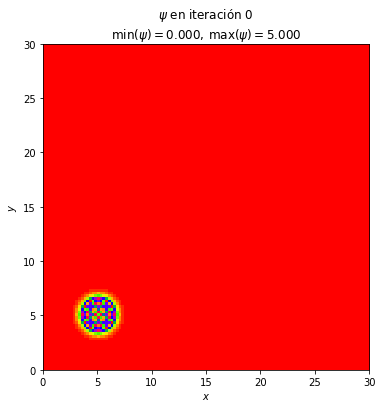

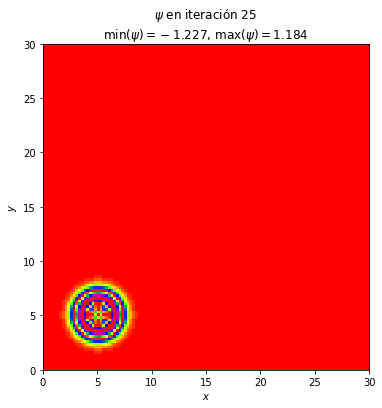

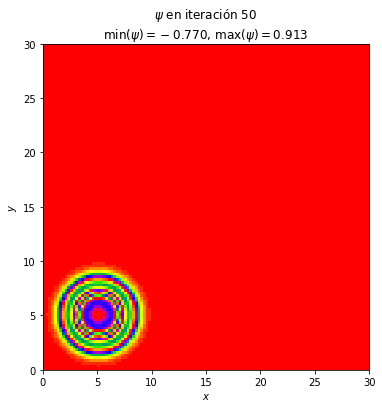

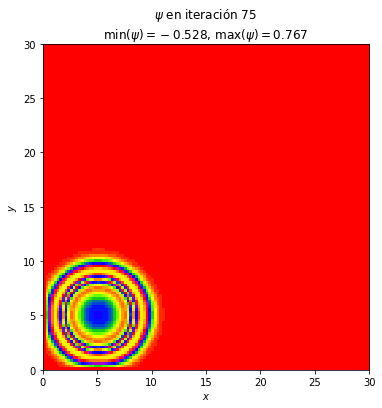

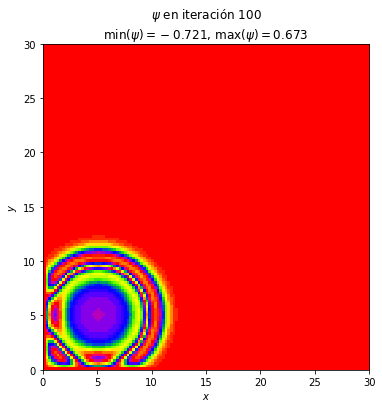

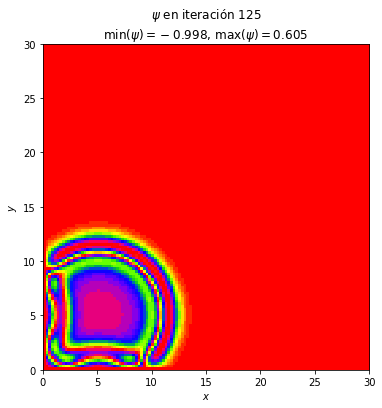

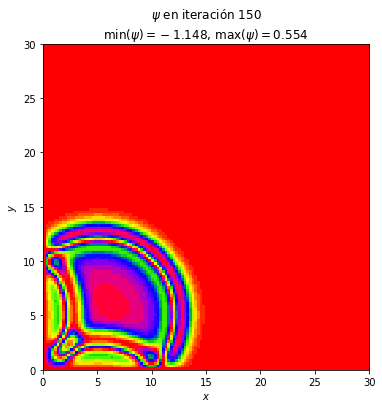

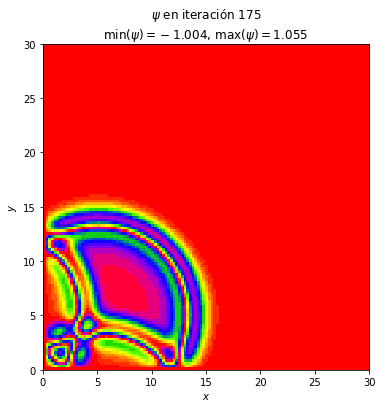

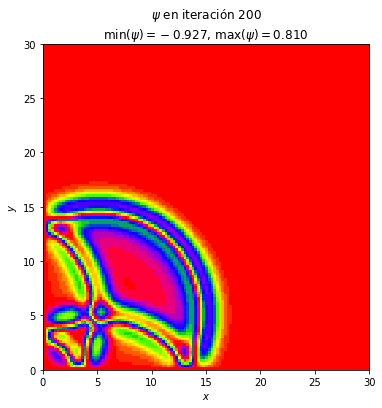

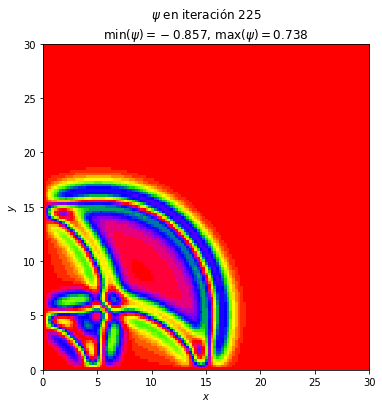

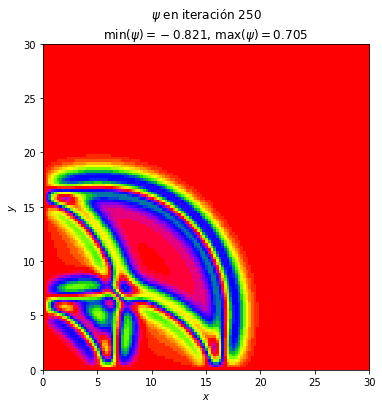

In [16]:
%cd ~/CactusTutorial/CactusFW2/
file_data = np.genfromtxt("../../simulations/WaveEquation1/output-0000/WaveEquation1/psi.xy.asc")

iters = np.unique(file_data[:, 0])
# Calcula máximo y mínimo global.
psi_min, psi_max = np.min(file_data[:, 12]), np.max(file_data[:, 12])
# Vamos a graficar para cada iteración única.
for i in iters:
    # Extrae información correspondiendte a la iteración actual.
    grid = file_data[file_data[:,0] == i, :]
    # Mallas x, y.
    x = grid[:,9]
    x_min, x_max = np.min(x), np.max(x)
    y = grid[:,10]
    y_min, y_max = np.min(y), np.max(y)
    # Valor de psi.
    psi = grid[:,12]
    # Hay que hacer de psi un arreglo bidimensional.
    # Necesitamos el número de elemntos únicos en x y y.
    psi_2d = psi.reshape(len(np.unique(y)), len(np.unique(x)))
    # Genera figura.
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(psi_2d[:,:], cmap, clim=(psi_min, psi_max), origin='lower', extent = [x_min, x_max, y_min, y_max])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title(r"$\psi$ en iteración $%d$" % i  +  '\n' +  r"$\min(\psi) = %3.3f,\, \max(\psi) = %3.3f$" % (np.min(psi_2d), np.max(psi_2d)))
    #plt.colorbar(im, ax = ax)
    plt.show()

Una observación podría ser que sólo corrimos con un procesador. ¿Por qué? Probemos correr con dos y ver qué pasa...

In [ ]:
!rm -fr ~/simulations/WaveEquation1
!./simfactory/bin/sim create-run WaveEquation1.par --procs=2 --num-threads=1

Parameter file: /home/santiago/CactusTutorial/CactusFW2/WaveEquation1.par
Skeleton Created
Job directory: "/home/santiago/simulations/WaveEquation1"
Executable: "/home/santiago/CactusTutorial/CactusFW2/exe/cactus_sim"
Option list: "/home/santiago/simulations/WaveEquation1/SIMFACTORY/cfg/OptionList"
Submit script: "/home/santiago/simulations/WaveEquation1/SIMFACTORY/run/SubmitScript"
Run script: "/home/santiago/simulations/WaveEquation1/SIMFACTORY/run/RunScript"
Parameter file: "/home/santiago/simulations/WaveEquation1/SIMFACTORY/par/WaveEquation1.par"
Simulation name: WaveEquation1
Assigned restart id: 0 
Running simulation WaveEquation1
Preparing:
++ set -e
++ cd /home/santiago/simulations/WaveEquation1/output-0000-active
++ echo Checking:
Checking:
++ pwd
/home/santiago/simulations/WaveEquation1/output-0000-active
++ hostname
santiago-inspiron
++ date
mié may 30 17:10:38 CDT 2018
++ echo Environment:
Environment:
++ export CACTUS_NUM_PROCS=2
++ CACTUS_NUM_PROCS=2
++ export CACTUS_NUM

INFO (CycleClock): Calibrated CycleClock: 0.385794 ns per clock tick (2.59206 GHz)
INFO (Vectors): Using vector size 1 for architecture scalar (no vectorisation, 64-bit precision)
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR info I/O provided by CarpetIOBasic
--------------------------------------------------------------------------------
MoL: Generalized time integration.
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 2D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 3D ASCII I/O pro

       51     2.550 |   -0.7509101    0.9037071 |   -1.6752336    0.7683483
       52     2.600 |   -0.7381890    0.8926540 |   -1.6432159    0.7677978
       53     2.650 |   -0.7221845    0.8888069 |   -1.6350163    0.7582968
       54     2.700 |   -0.7079150    0.8839787 |   -1.6270517    0.7473031
       55     2.750 |   -0.6964637    0.8740304 |   -1.5998401    0.7493034
       56     2.800 |   -0.6832753    0.8659908 |   -1.5792803    0.7455052
       57     2.850 |   -0.6694573    0.8643661 |   -1.5801146    0.7349040
       58     2.900 |   -0.6599205    0.8563398 |   -1.5614658    0.7310699
       59     2.950 |   -0.6497698    0.8468101 |   -1.5335070    0.7316019
---------------------------------------------------------------------------
Iteration      Time |              WAVETOY::psi |              WAVETOY::phi
                    |      minimum      maximum |      minimum      maximum
---------------------------------------------------------------------------
       60   

      151     7.550 |   -1.1331750    0.5500343 |   -1.3940805    2.5502206
      152     7.600 |   -1.1278367    0.5486015 |   -1.4044136    2.5624036
      153     7.650 |   -1.1223296    0.5487817 |   -1.3973749    2.5444677
      154     7.700 |   -1.1094625    0.5455709 |   -1.3726016    2.4966134
      155     7.750 |   -1.1033594    0.5422900 |   -1.3675435    2.4195445
      156     7.800 |   -1.1009051    0.5430998 |   -1.3786795    2.3738238
      157     7.850 |   -1.0913736    0.5414192 |   -1.3725868    2.3256577
      158     7.900 |   -1.0788888    0.6093355 |   -1.3488579    2.2532273
      159     7.950 |   -1.0807356    0.6779124 |   -1.3521946    2.1875242
---------------------------------------------------------------------------
Iteration      Time |              WAVETOY::psi |              WAVETOY::phi
                    |      minimum      maximum |      minimum      maximum
---------------------------------------------------------------------------
      160   

--------------------------------------------------------------------------------
Done.
++ echo Stopping:
Stopping:
++ date
mié may 30 17:10:40 CDT 2018
++ echo Done.
Done.
mié may 30 17:10:40 CDT 2018
Simfactory Done at date: 0


In [ ]:
%cd ~/CactusTutorial/CactusFW2/
file_data = np.genfromtxt("../../simulations/WaveEquation1/output-0000/WaveEquation1/psi.xy.asc")

iters = np.unique(file_data[:, 0])
# Calcula máximo y mínimo global.
psi_min, psi_max = np.min(file_data[:, 12]), np.max(file_data[:, 12])
# Vamos a graficar para cada iteración única.
for i in iters:
    # Extrae información correspondiendte a la iteración actual.
    grid = file_data[file_data[:,0] == i, :]
    # Mallas x, y.
    x = grid[:,9]
    x_min, x_max = np.min(x), np.max(x)
    y = grid[:,10]
    y_min, y_max = np.min(y), np.max(y)
    # Valor de psi.
    psi = grid[:,12]
    # Hay que hacer de psi un arreglo bidimensional.
    # Necesitamos el número de elemntos únicos en x y y.
    psi_2d = psi.reshape(len(np.unique(y)), len(np.unique(x)))
    # Genera figura.
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(psi_2d[:,:], cmap, clim=(psi_min, psi_max), origin='lower', extent = [x_min, x_max, y_min, y_max])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title(r"$\psi$ en iteración $%d$" % i  +  '\n' +  r"$\min(\psi) = %3.3f,\, \max(\psi) = %3.3f$" % (np.min(psi_2d), np.max(psi_2d)))
    #plt.colorbar(im, ax = ax)
    plt.show()

/home/santiago/CactusTutorial/CactusFW2


Claramente algo está mal y se debe a que no se está compartiendo la información entre procesadores. Esto se arregla con una sincronización dentro de `schedule.ccl`.

In [ ]:
%%writefile ~/CactusTutorial/CactusFW2/arrangements/Utils/WaveToy/schedule.ccl
## Definiciones de programación/agenda para WaveToy.
##
## No habrá memoria asignada a un grupo a menos de que exista una
## declaración de alamacenaje explícitamente en este archivo.
## Especificamos el número de niveles a alocar con corchetes.
## Ejemplo:
#storage: force_group[3]
#storage: scalar_group
##
##
##
## En este archivo también se debe indicar dónde van a correr las
## subrutinas o funciones declaradas para este Thorn. Como menos,
## se debe esepcificar el lenguaje en el que está escrita la subrutina.
## Este puede ser C (para C y C++) o Fortran (para Fortran90). 
## Adicionalmente se debe decir en qué etapa se va a correr.
## Ejemplo:
#SCHEDULE init_function at CCTK_INIT
#{
#  LANG: C
#} "Do some initial stuff"
##
##
## A continuación se asigna memoria para los grupo de WaveToy.
storage: evol_group[3], rhs_group
##
##
## Después se listan las subrutinas y sus etapas.
SCHEDULE init_wave_toy in CCTK_INITIAL
{
    LANG: C
} "Inicializa datos de la onda."

SCHEDULE evolve_wave_toy in MoL_CalcRHS
{
    LANG: C
    SYNC: WaveToy::evol_group
    SYNC: WaveToy::rhs_group
} "Evoluciona onda."

SCHEDULE wave_toy_registervars in MoL_Register
{
    LANG: C
} "Registra las variables para MoL."

In [ ]:
!time ./simfactory/bin/sim build -j 2 --thornlist=./wave_toy_thorn.th

In [ ]:
!rm -fr ~/simulations/WaveEquation1
!./simfactory/bin/sim create-run WaveEquation1.par --procs=2 --num-threads=1

In [ ]:
%cd ~/CactusTutorial/CactusFW2/
file_data = np.genfromtxt("../../simulations/WaveEquation1/output-0000/WaveEquation1/psi.xy.asc")

iters = np.unique(file_data[:, 0])
# Calcula máximo y mínimo global.
psi_min, psi_max = np.min(file_data[:, 12]), np.max(file_data[:, 12])
# Vamos a graficar para cada iteración única.
for i in iters:
    # Extrae información correspondiendte a la iteración actual.
    grid = file_data[file_data[:,0] == i, :]
    # Mallas x, y.
    x = grid[:,9]
    x_min, x_max = np.min(x), np.max(x)
    y = grid[:,10]
    y_min, y_max = np.min(y), np.max(y)
    # Valor de psi.
    psi = grid[:,12]
    # Hay que hacer de psi un arreglo bidimensional.
    # Necesitamos el número de elemntos únicos en x y y.
    psi_2d = psi.reshape(len(np.unique(y)), len(np.unique(x)))
    # Genera figura.
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(psi_2d[:,:], cmap, clim=(psi_min, psi_max), origin='lower', extent = [x_min, x_max, y_min, y_max])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title(r"$\psi$ en iteración $%d$" % i  +  '\n' +  r"$\min(\psi) = %3.3f,\, \max(\psi) = %3.3f$" % (np.min(psi_2d), np.max(psi_2d)))
    #plt.colorbar(im, ax = ax)
    plt.show()

Como última parte, vamos a usar un AMR.

In [ ]:
%%writefile ~/CactusTutorial/CactusFW2/WaveEquation2.par
ActiveThorns = "WaveToy coordbase carpet cartgrid3d MoL"

Cactus::cctk_itlast = 250

# the output dir will be named after the parameter file name
IO::out_dir = $parfile

# The set of parameters required to specify the grid...
Carpet::domain_from_coordbase = "yes"
CartGrid3D::type = "coordbase"
CartGrid3D::avoid_origin = "no"
CoordBase::domainsize = "minmax"
CoordBase::spacing    = "gridspacing"
CoordBase::xmin =  0
CoordBase::xmax =  30
CoordBase::ymin =  0
CoordBase::ymax =  30
CoordBase::zmin =  0.0
CoordBase::zmax =  0.0
CoordBase::dx   =  0.25
CoordBase::dy   =  0.25

# Because we're doing a 2D code...
CoordBase::boundary_size_z_lower     = 0
CoordBase::boundary_size_z_upper     = 0
CoordBase::boundary_shiftout_z_lower = 1
CoordBase::boundary_shiftout_z_upper = 1

# The time integration scheme...
MoL::ODE_Method = "RK3"

# The next section is required if you want some kind of confirmation
# on the console that your code is actually doing anything...
ActiveThorns = "CarpetIOBasic IOUtil CarpetReduce SymBase"
IO::out_fileinfo="all"
IOBasic::outInfo_every = 1
IOBasic::outInfo_vars = "WaveToy::phi WaveToy::psi"

# Get some data!
ActiveThorns = "CarpetIOASCII"
CarpetIOASCII::compact_format = false
IOASCII::out2D_every = 25
IOASCII::out2D_xyplane_z = 0
IOASCII::out2D_vars = "WaveToy::psi WaveToy::phi"
IOASCII::out2D_xz = "no"
IOASCII::out2D_yz = "no"
IOASCII::output_ghost_points = "no"

# Taking too big a time step can lead to unstable evolution.
# You can control that with dtfac and thorn Time.
ActiveThorns = "Time"
Time::dtfac = .2

### MESH REFINEMENT ####
ActiveThorns = "CarpetRegrid2"
Carpet::init_fill_timelevels = "true"
Carpet::max_refinement_levels = 2
CarpetRegrid2::num_centres = 1
CarpetRegrid2::num_levels_1 = 2
CarpetRegrid2::position_x_1 = 8.0
CarpetRegrid2::position_y_1 = 8.0
CarpetRegrid2::position_z_1 = 8.0
CarpetRegrid2::radius_1[1] = 8.0

#MoL::disable_prolongation        = "no"

### Dissipation is numerical noise added to mitigate
### grid boundary effects seen in some AMR simulations.
#ActiveThorns = "Dissipation Spacemask SPHERICALSURFACE"
#Dissipation::vars = "WaveToy::psi WaveToy::phi"
#Dissipation::order = 1

In [ ]:
!rm -fr ~/simulations/WaveEquation2
!./simfactory/bin/sim create-run WaveEquation2.par --procs=2 --num-threads=1

In [ ]:
%cd ~/CactusTutorial/CactusFW2/
file_data = np.genfromtxt("../../simulations/WaveEquation2/output-0000/WaveEquation2/psi.xy.asc")

iters = np.unique(file_data[:, 0])
# Calcula máximo y mínimo global.
psi_min, psi_max = np.min(file_data[:, 12]), np.max(file_data[:, 12])
# Vamos a graficar para cada iteración única.
for i in iters:
    # Extrae información correspondiendte a la iteración actual.
    amr_grid = file_data[file_data[:,0] == i, :]
    # Niveles de refinamiento.
    for rl in range(10):
        grid = amr_grid[amr_grid[:,2]==rl,:]
        # Mallas x, y.
        x = grid[:,9]    
        y = grid[:,10]
        # Valor de psi.
        psi = grid[:,12]
        # Revisa máximo nivel de refinamiento.
        if psi.shape[0] == 0:
            continue
        print "Nivel de refinamiento = ", rl
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        # Hay que hacer de psi un arreglo bidimensional.
        # Necesitamos el número de elemntos únicos en x y y.
        psi_2d = psi.reshape(len(np.unique(y)), len(np.unique(x)))
        # Genera figura.
        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(psi_2d[:,:], cmap, clim=(psi_min, psi_max), origin='lower', extent = [x_min, x_max, y_min, y_max])
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$y$")
        ax.set_title(r"$\psi$ en iteración $%d$" % i  +  '\n' +  r"$\min(\psi) = %3.3f,\, \max(\psi) = %3.3f$" % (np.min(psi_2d), np.max(psi_2d)))
        #plt.colorbar(im, ax = ax)
        plt.show()